## D5i. MODIS Unbalanced dataset 80k 2013 - 2019  min 25 class, 0,1 - Model training and validation :
This model will use data obtained from MODIS (one day only), NDWI, NDWI_ICE, DEM SLOPE and EUCLIDEAN_NORM to predict water and non-water features. For all years

#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import seaborn as sns
import datetime
from sklearn import metrics
import joblib
# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Load sampled eopatches:

In [3]:
# pick dataset_name
input_dataset_file_name = '_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/'

dataset_filepath_2013 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10{}'.format(input_dataset_file_name)
dataset_filepath_2014 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10{}'.format(input_dataset_file_name)
dataset_filepath_2015 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2015_05-2015_10{}'.format(input_dataset_file_name)
dataset_filepath_2016 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2016_05-2016_10{}'.format(input_dataset_file_name)
dataset_filepath_2017 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2017_05-2017_10{}'.format(input_dataset_file_name)
dataset_filepath_2018 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2018_05-2018_10{}'.format(input_dataset_file_name)
dataset_filepath_2019 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name)

dataset_path_list = [dataset_filepath_2013,
                dataset_filepath_2014,
                dataset_filepath_2015,
                dataset_filepath_2016,
                dataset_filepath_2017,
                dataset_filepath_2018,
                dataset_filepath_2019]

#### 2. Choose test eopatches

In [4]:
#list_of_available_patches_2013 = io_utils.get_list_of_eopatches(dataset_filepath_2013)

#test_eppatches_chosen_names = np.random.choice(list_of_available_patches_2013, 7, replace=True)
#test_eppatches_chosen_names

test_eppatches_chosen_names = np.array(['2974_maxcc_0.05_x-3_y-135', '2976_maxcc_0.05_x-3_y-137',
       '3179_maxcc_0.05_x-5_y-137', '3067_maxcc_0.05_x-4_y-138',
       '3180_maxcc_0.05_x-5_y-138', '3473_maxcc_0.05_x-7_y-134',
       '2975_maxcc_0.05_x-3_y-136'], dtype='<U25')


In [5]:
%%time
train_eopatches= []
test_eopatches= []
train_eopatches_filenames = []
test_eopatches_filenames = []

for eopatches_filepath in dataset_path_list:

    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    list_in_chunks = io_utils.chunkIt(list_of_available_patches, 2 ) # number of chunks- 1 bc all can go
    for chunk in list_in_chunks:
        #print('Doing now following eopatches:', chunk )
        for eopatch_name in chunk:
            if eopatch_name in test_eppatches_chosen_names:
                test_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                test_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))
                
            else:
                train_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                train_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))    
print(len(train_eopatches))
print(len(test_eopatches))

221
46
Wall time: 4.37 s


In [6]:
# check if all eopatches from all years are there. 
test_eopatches_filenames[:10]

['../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/2974_maxcc_0.05_x-3_y-135',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/2975_maxcc_0.05_x-3_y-136',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/3179_maxcc_0.05_x-5_y-137',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/3180_maxcc_0.05_x-5_y-138',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/3473_maxcc_0.05_x-7_y-134',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/2974_maxcc_0.05_x-3_y-135',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/2975_maxcc_0.05_x-3_y-136',
 '../../data/EOPatches/LAND

In [8]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file ='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name))
eo_patch

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/3180_maxcc_0.05_x-5_y-138


EOPatch(
  data: {
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED: numpy.ndarray(shape=(14, 80000, 1, 13), dtype=float32)
  }
  mask: {
    WATER_MASK_ST_025_SAMPLED: numpy.ndarray(shape=(14, 80000, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    DEM_RAW_AVG: 1217.3173
    DEM_RAW_MAX: 1330.0
    DEM_RAW_MED: 1210.0
    DEM_RAW_MIN: 1073.0
    DEM_RAW_STD: 49.574226
    DEM_RAW_VAR: 2457.604
    index_x: 5
    index_y: 138
    maxcc: '0.05'
    patch_index: 3180
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-05-01', '2019-10-31')
  }
  bbox: BBox(((420000.0, 8110000.0), (430000.0, 8120000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2019, 7, 1, 0, 1), ..., datetime.datetime(2019, 9, 29, 15, 36, 50)], length=14
)

####  3. Fetch and organise dataset

In [10]:
# Definition of the train and test patch IDs

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in train_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, bands))
labels_train = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in train_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, answer=True, False))
features_test = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in test_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0 ])
labels_test = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in test_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])

In [13]:
#reshape to  (number_of_patches x time, width, height, bands)
features_train_stacked = np.vstack(features_train)
labels_train_stacked = np.vstack(labels_train)
features_test_stacked = np.vstack(features_test)
labels_test_stacked = np.vstack(labels_test)

# get shape
p_train_x_time, w, h, b = features_train_stacked.shape
p_test_x_time, w, h, b = features_test_stacked.shape


# reshape to n x m
#n - no of observation
#m - no of features, - bands in my case, misssing DEM

features_train = features_train_stacked.reshape(p_train_x_time * w * h, b)
labels_train = labels_train_stacked.reshape(p_train_x_time * w * h, 1)
features_test = features_test_stacked.reshape(p_test_x_time * w * h, b)
labels_test = labels_test_stacked.reshape(p_test_x_time * w * h, 1)


#@TODO
# remove points with no reference from training (so we dont train to recognize "no data")
# interpolation????
#mask_train = labels_train == 0
#features_train = features_train[~mask_train]
#labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
#mask_test = labels_test == 0
#features_test = features_test[~mask_test]
#labels_test = labels_test[~mask_test]


####  5. Pickle dataset

In [14]:
import pickle

dataset = [features_train, labels_train, features_test, labels_test ]
dataset_name = 'dataset_2013_05-2019_10_sptl_smpl_80k_pr_patch_balanced_classes_1_2_min_25_test_7_test_fixed'

with open('{}.pickle'.format(dataset_name), 'wb') as output:
    pickle.dump(dataset, output)

OverflowError: cannot serialize a bytes object larger than 4 GiB

####  4. Data statistics

In [15]:
#to compare old data distribution (little less )

print('TRAIN DATA:')
tot_obs = np.size(labels_train)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_train)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )

print('\nTEST DATA:')

tot_obs = np.size(labels_test)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_test)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )
# dataset is half of the previous one!!!

TRAIN DATA:
Total observations:  121200000
Total water count 2400932
Percent of water feature among data: 0.0198096699669967

TEST DATA:
Total observations:  27280000
Total water count 772016
Percent of water feature among data: 0.028299706744868036


####  4. Model training

In [16]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = LGBMClassifier(boosting='gbdt',
    objective='binary',
    learning_rate=0.1,
    metric='binary_logloss', #mae: mean absolute error mse: mean squared error
    #class_weight= 'balanced' 
                       
)

# train the model
model.fit(features_train, labels_train)


C:\Users\Kamil\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Kamil\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Wall time: 6min 21s


LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

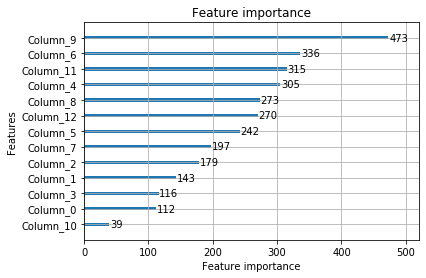

In [20]:
import lightgbm as lgb
_ = lgb.plot_importance(model)

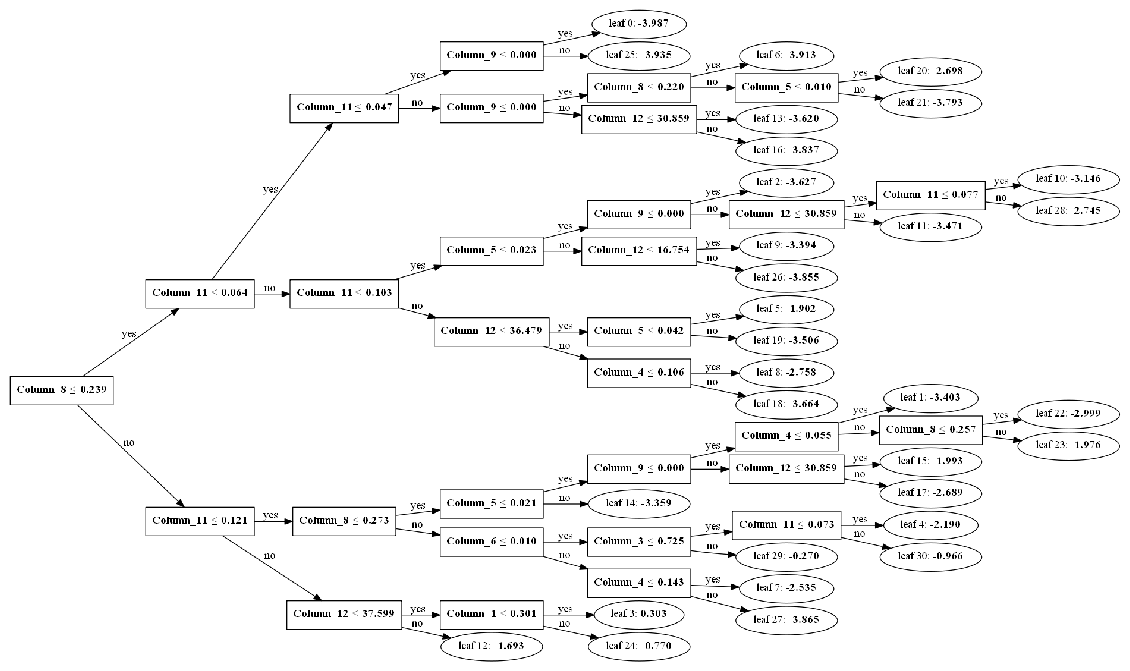

In [21]:
_ = lgb.plot_tree(model, figsize=(20, 20))

In [72]:
# uncomment to save the model
model_base_name = 'NEW_model_20000_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_50'
joblib.dump(model, './{}.pkl'.format(model_base_name))

['./NEW_model_20000_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_50.pkl']

####  5. Model Validation

In [17]:
print('TEST:')
# predict the test labels
plabels_test = model.predict(features_test)
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

# predict the train labels
plabels_train = model.predict(features_train)
print('TRAIN:')
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_train, plabels_train)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_train, plabels_train, average='weighted')))

TEST:
Classification accuracy 97.3%
Classification F1-score 96.5%
TRAIN:
Classification accuracy 98.2%
Classification F1-score 97.6%


In [22]:
actual_water = np.count_nonzero(labels_test)
predicted_water = np.count_nonzero(plabels_test)

print('Water Test data size:',actual_water)

tp = np.count_nonzero(np.logical_and(labels_test.squeeze(), plabels_test.squeeze()))
print('Water True positive:', tp, 'and recall', 100* tp /actual_water, 'and precision:', tp /predicted_water)


Water Test data size: 772016
Water True positive: 121715 and recall 15.76586495616671 and precision: 0.5961044939858167


In [23]:
class_labels = np.unique(labels_test)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [24]:

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}% |  {2:2.1f}%  | {3:2.1f}%'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 98.6% |  99.7%  | 97.6%
         * water                = 24.9% |  15.8%  | 59.6%


#### 6. Plot the standard and transposed Confusion Matrix:

In [25]:
import itertools
import matplotlib.pyplot as plt
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

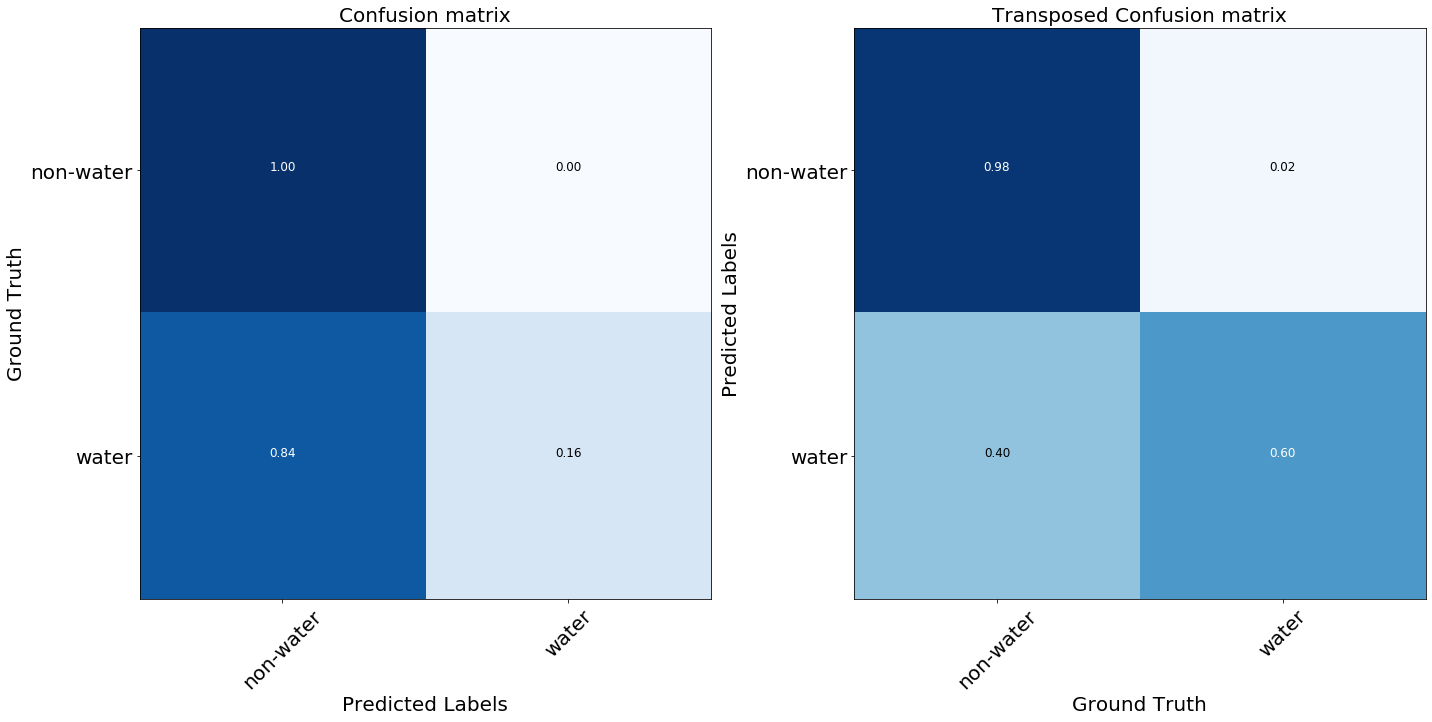

In [26]:
ig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Ground Truth', 
                      xlabel='Predicted Labels',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Ground Truth', 
                      ylabel='Predicted Labels',
                      title='Transposed Confusion matrix');

plt.tight_layout()

#### 7. Plot dataset balance

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


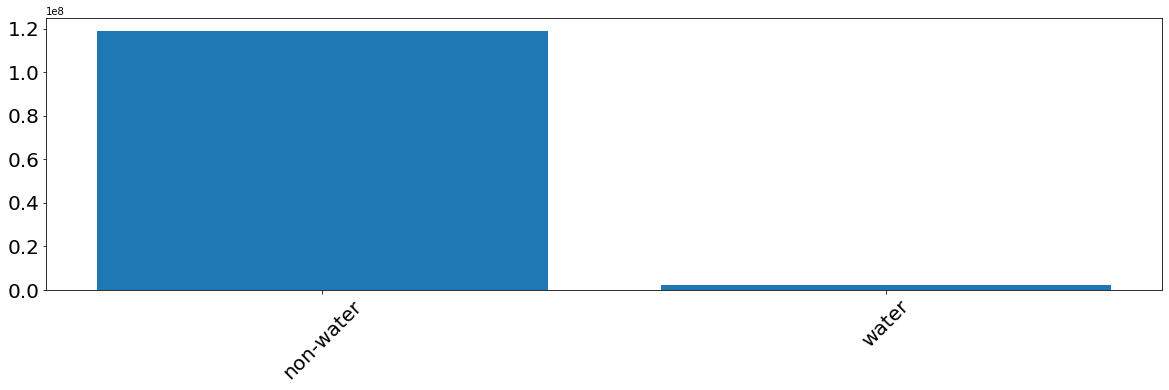

In [27]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

#### 8. ROC curves and AUC metrics
Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [28]:
class_labels_zero_one = 1*class_labels
l_one_zero = 1*labels_test
l_one_zero.shape

(27280000, 1)

In [29]:
from sklearn import preprocessing
scores_test = model.predict_proba(features_test)

labels_binarized = preprocessing.label_binarize((1*labels_test).tolist(), classes=[0, 1, 3])
labels_binarized.shape

(27280000, 3)

In [30]:

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate([1, 2]):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


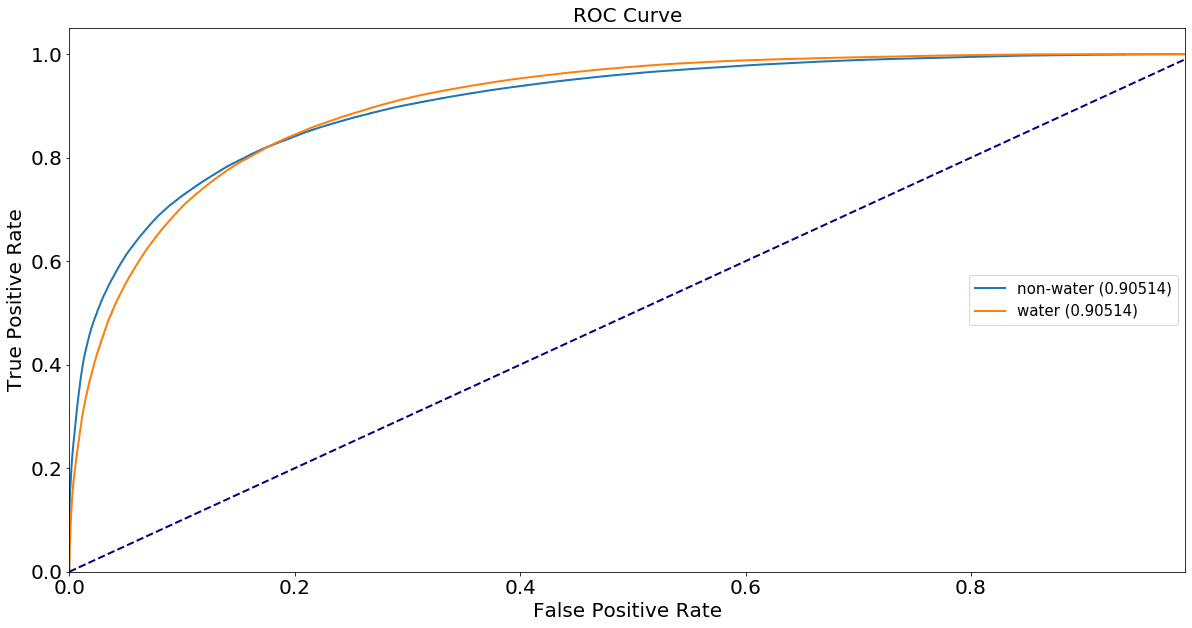

In [31]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

#### 9. Most important features:
Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them.

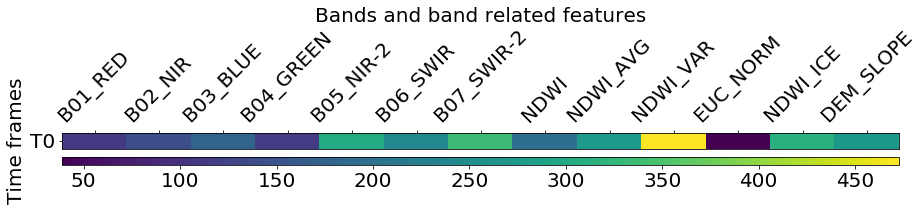

In [35]:
# names of features
fnames = ['B01_RED', 'B02_NIR', 'B03_BLUE', 'B04_GREEN', 'B05_NIR-2', 'B06_SWIR', 'B07_SWIR-2', 'NDWI', 'NDWI_AVG','NDWI_VAR', 'EUC_NORM','NDWI_ICE', 'DEM_SLOPE', ]

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((1, b))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(1), ['T{}'.format(i) for i in range(1)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

In [36]:
model.feature_importances_

array([112, 143, 179, 116, 305, 242, 336, 197, 273, 473,  39, 315, 270])

#### 10. Visualization of the results

In [37]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = ftrs.reshape(t * w * h, f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(t, w, h )
        plabels = plabels[..., np.newaxis]
        #eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return plabels

In [38]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/',  patch_id=6, random_choice=True)
eo_patch

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3174_maxcc_0.05_x-5_y-132


EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(26, 333, 333, 11), dtype=float32)
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE: numpy.ndarray(shape=(26, 333, 333, 13), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(26, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(26, 333, 333, 11), dtype=float32)
    MODIS_AVG_NBR_19: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(26, 333, 333, 1), dtype=float32)
  

In [41]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_RAW_NDWI_NRB_19_NORM_SLOPE'), 'WATER_MASK_ST_025')

predictions = []
predictions.append(predict_patch.execute(eo_patch))

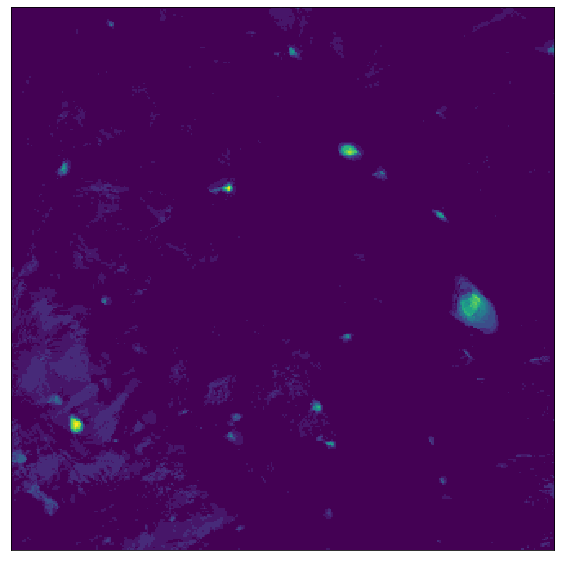

In [42]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-07-17 00:01:03
Ploting...


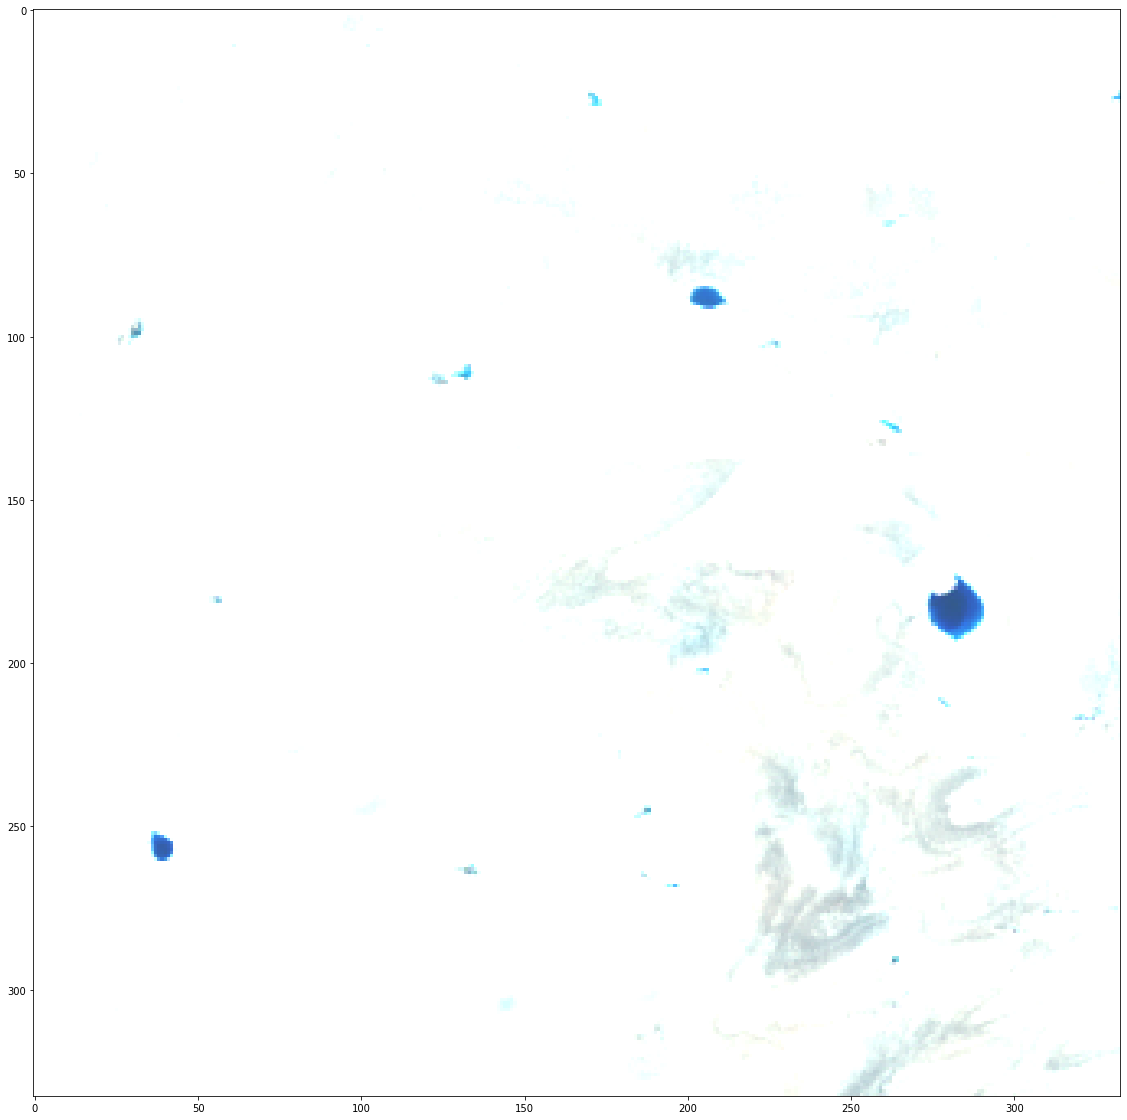

In [43]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, datetime_idx=15 )

2019-07-17 00:01:03
Ploting...


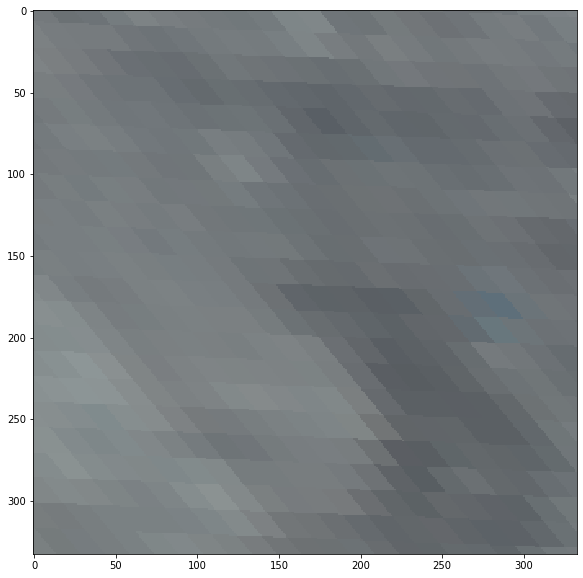

In [44]:
plot_utils.plot_RGB_MODIS_image(eo_patch, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=15)

In [45]:
patch_no = 15
reference_patch = eo_patch.mask['WATER_MASK_ST_025'][patch_no]
inspected_patch = predictions[0][patch_no]

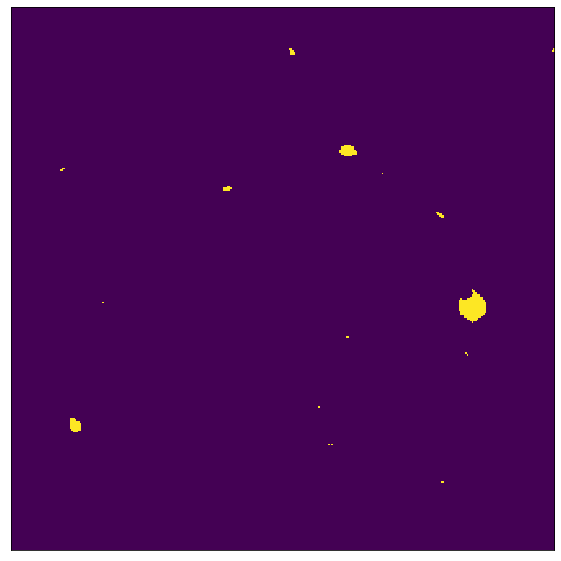

In [46]:
plot_utils.plot_matrix(reference_patch)

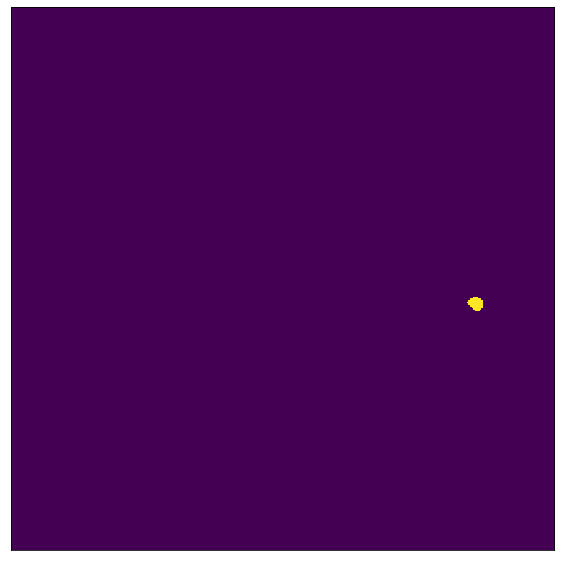

In [47]:
plot_utils.plot_matrix(inspected_patch)

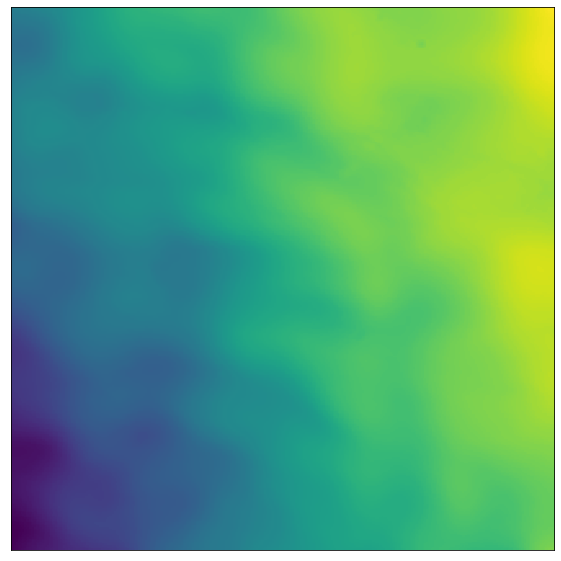

In [94]:
plot_utils.plot_matrix(eo_patch.data_timeless['DEM_RAW_LAYER'].squeeze())

2019-07-17 00:01:03
Band: 0
Band: 1
Band: 2
Band: 3
Band: 4
Band: 5
Band: 6
Band: 7
Band: 8
Band: 9
Band: 10
Band: 11
Band: 12


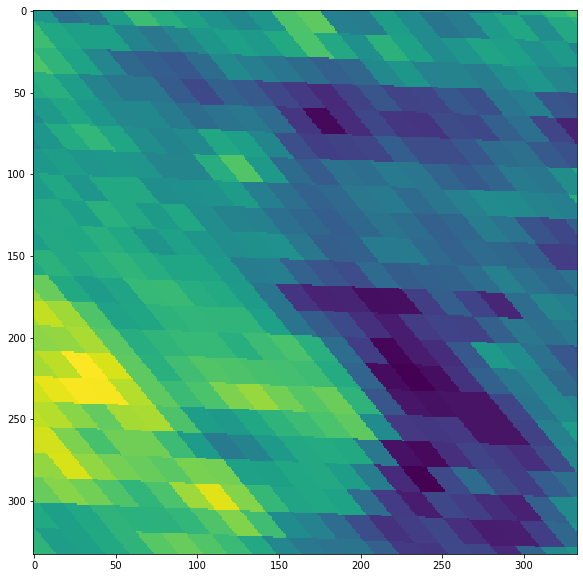

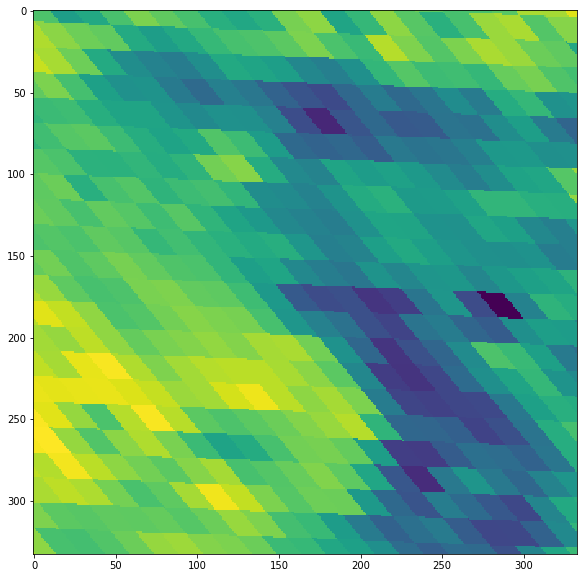

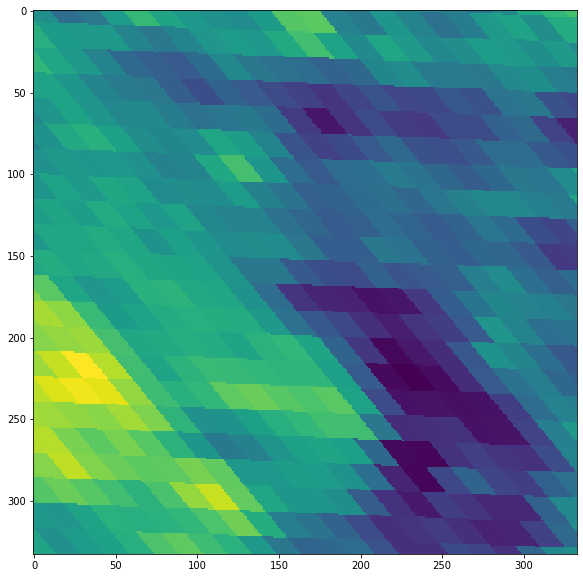

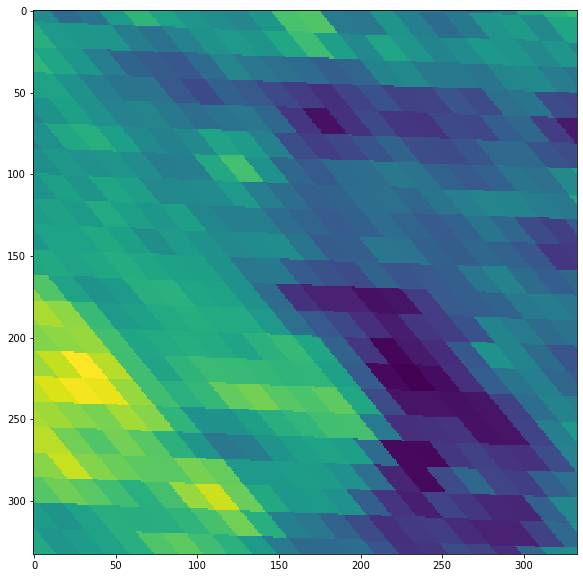

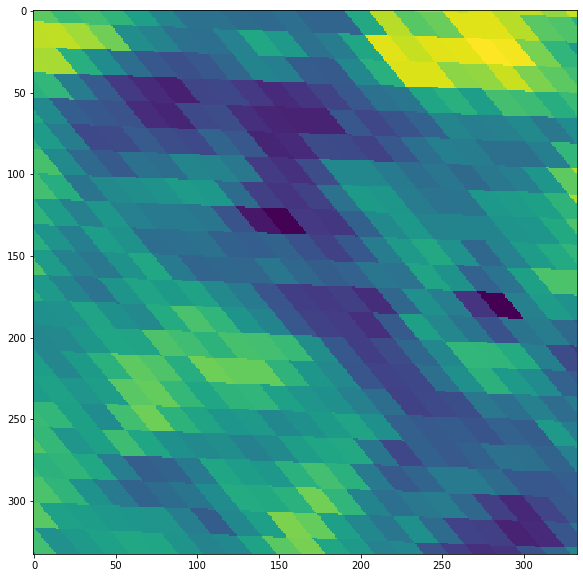

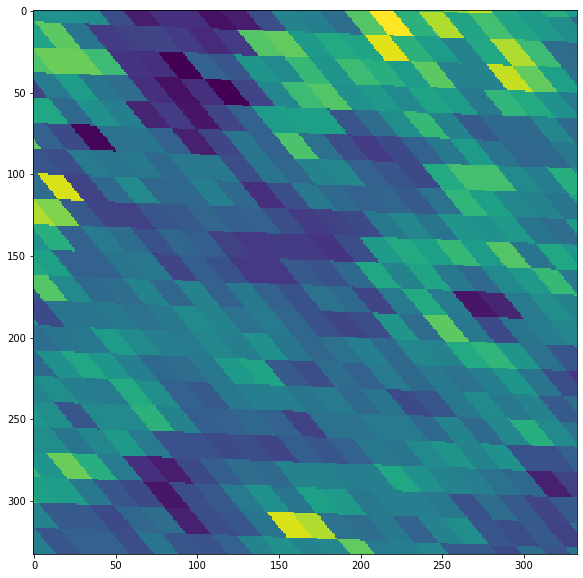

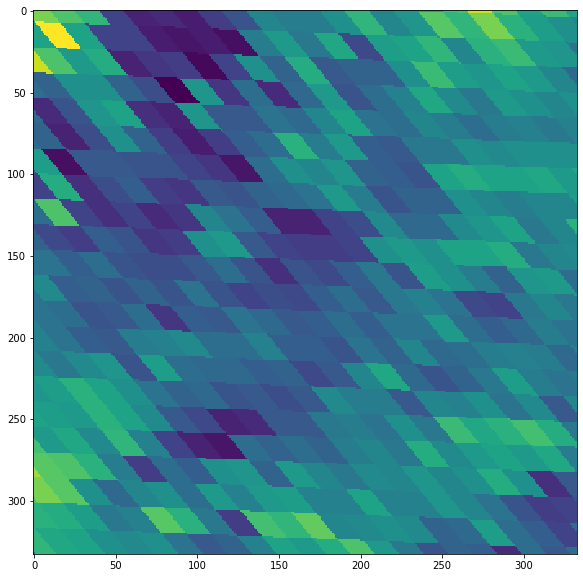

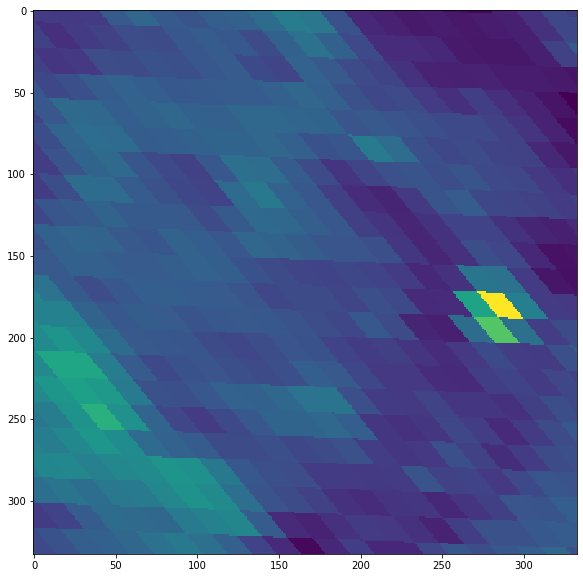

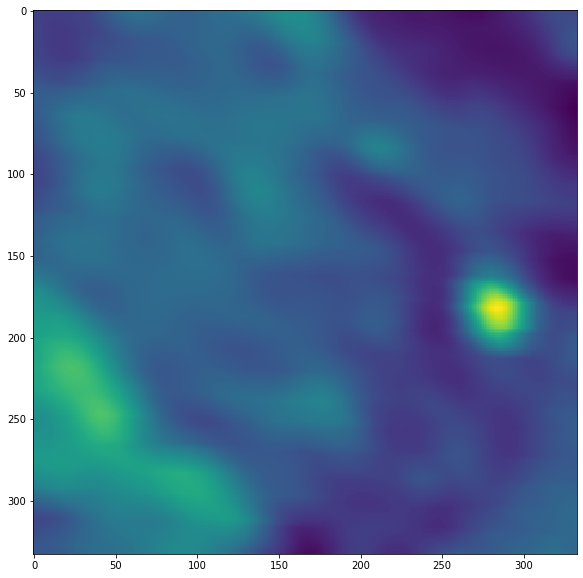

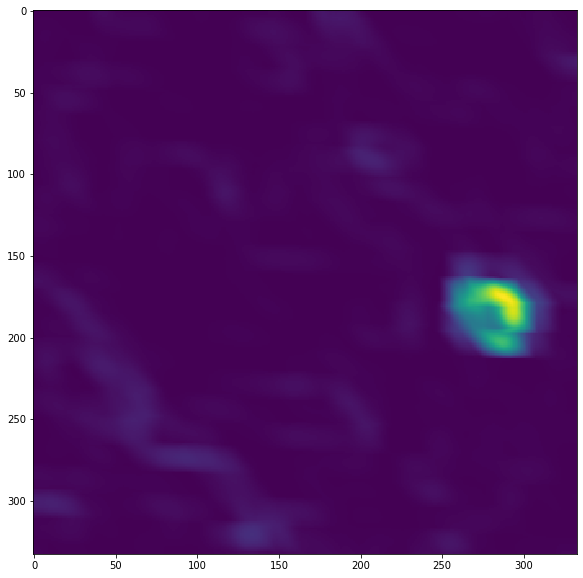

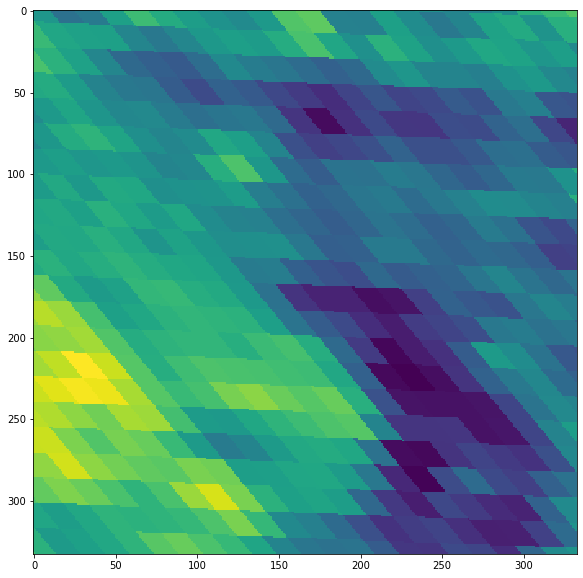

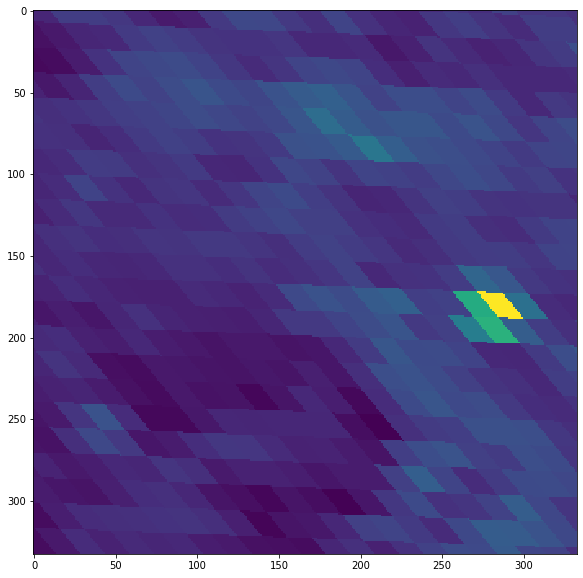

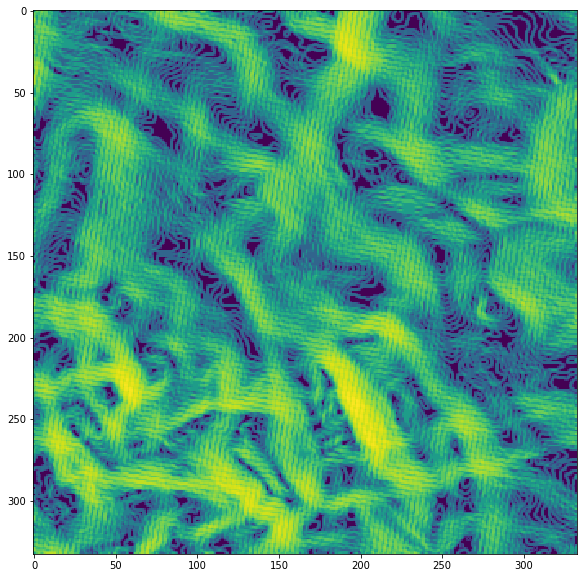

In [48]:
plot_utils.plot_all_bands_in_data_acces_name(eo_patch, data_acces_name='DATASET_RAW_NDWI_NRB_19_NORM_SLOPE', datetime_idx=15)

###  test patch

####  Load model

In [4]:
# uncomment to load the model and replace with your file, usually just correct the date
model_path = './NEW_model_20000_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_50.pkl'
model = joblib.load(model_path)

####  Load test eopatch 

In [ ]:
# Declare EOPatches

In [49]:
test_eopatches_filenames[-1]

'../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/3473_maxcc_0.05_x-7_y-134'

In [50]:
test_eo_patch_filepath = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3473_maxcc_0.05_x-7_y-134'

eo_patch_test = EOPatch.load(test_eo_patch_filepath) 
eo_patch_test

EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(28, 333, 333, 11), dtype=float32)
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE: numpy.ndarray(shape=(28, 333, 333, 13), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(28, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 11), dtype=float32)
    MODIS_AVG_NBR_19: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
  

In [53]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_RAW_NDWI_NRB_19_NORM_SLOPE'), 'WATER_MASK_ST_025')

predictions_test = []
predictions_test.append(predict_patch.execute(eo_patch_test))

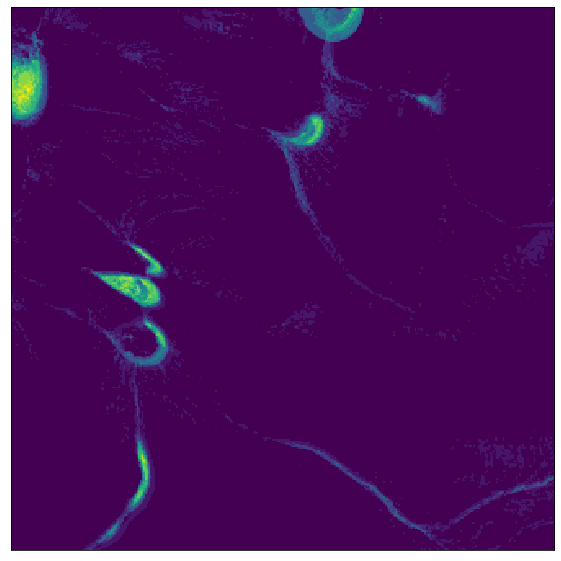

In [54]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch_test, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-07-17 00:01:03
Ploting...


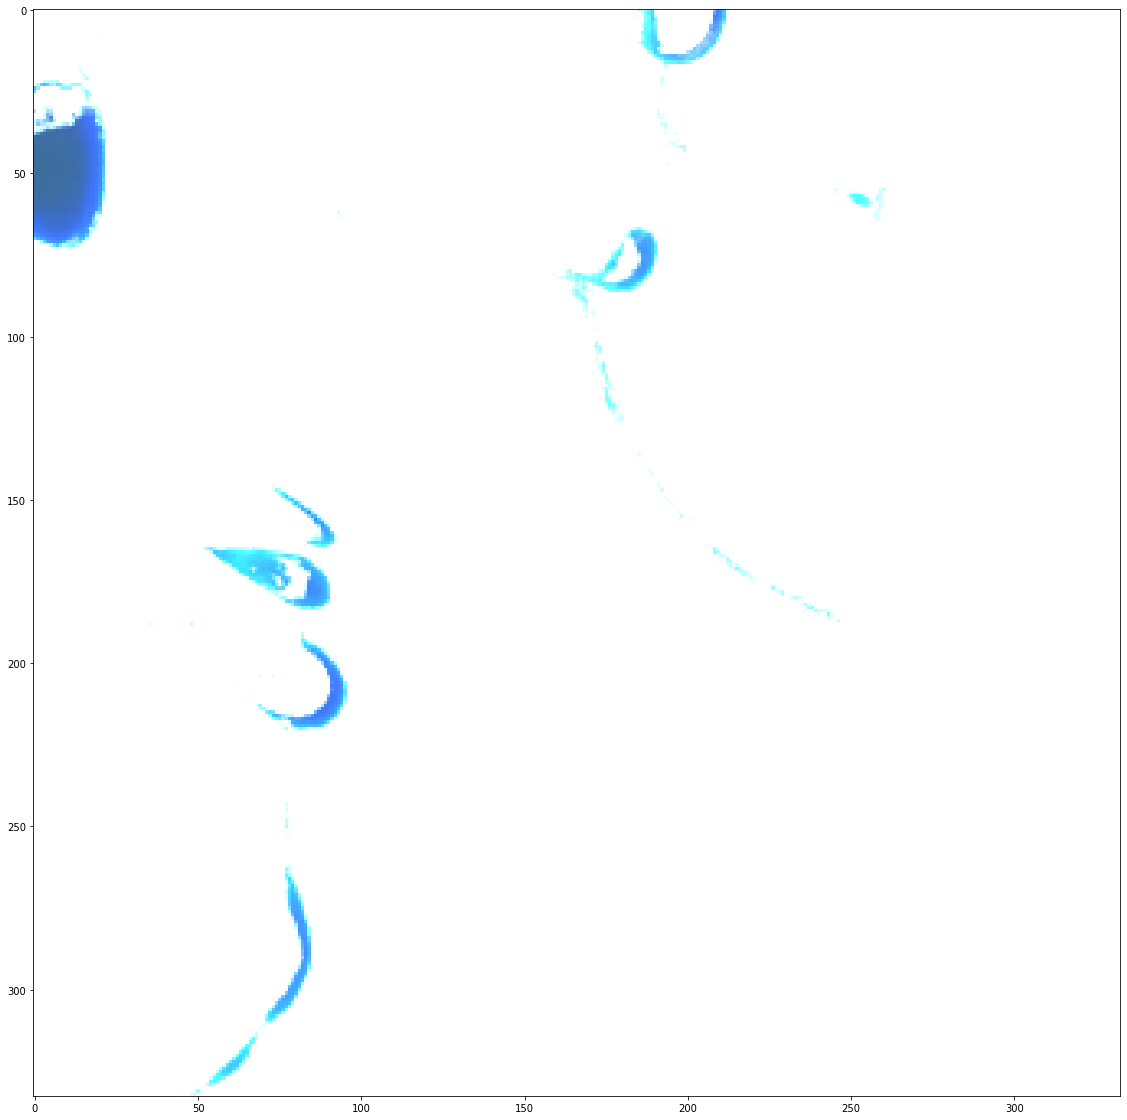

In [55]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch_test, datetime_idx=15 )

2019-07-17 00:01:03
Ploting...


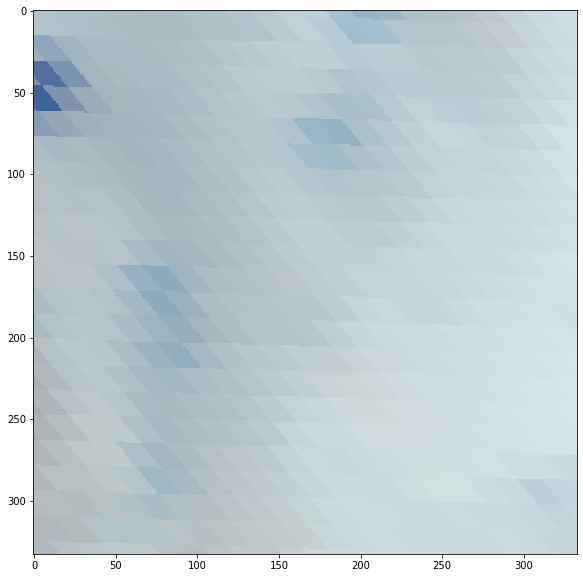

In [56]:
plot_utils.plot_RGB_MODIS_image(eo_patch_test, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=15)

In [57]:
patch_no = 15
reference_patch_test = eo_patch_test.mask['WATER_MASK_ST_025'][patch_no]
inspected_patch_test = predictions_test[0][patch_no]

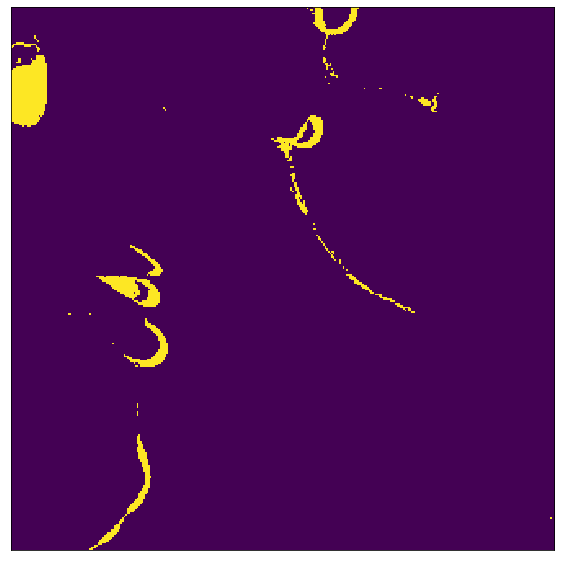

In [58]:
plot_utils.plot_matrix(reference_patch_test)

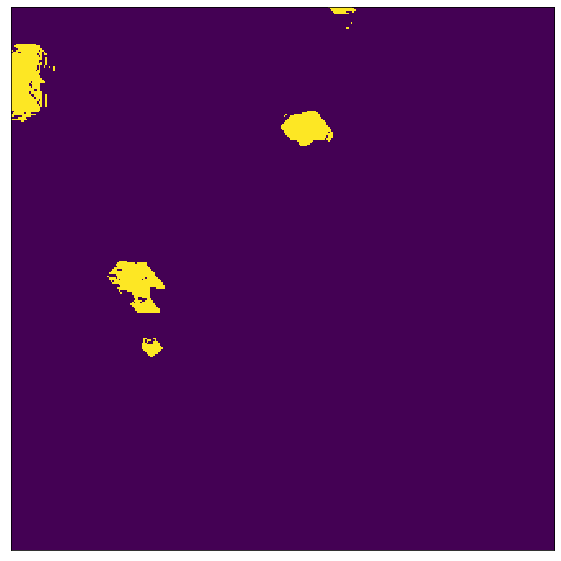

In [59]:
plot_utils.plot_matrix(inspected_patch_test)

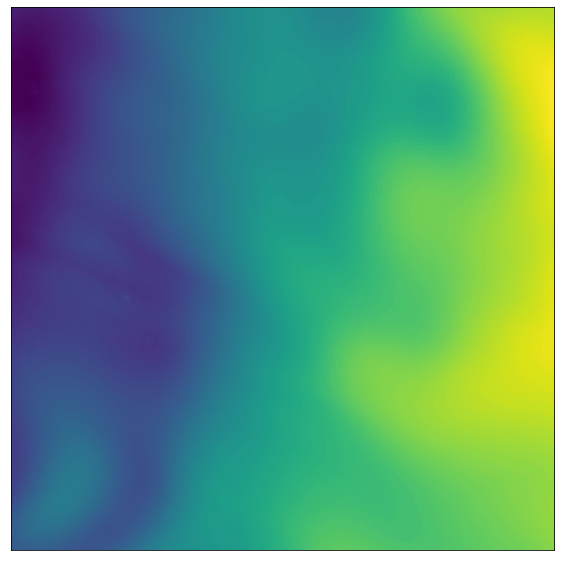

In [60]:
plot_utils.plot_matrix(eo_patch_test.data_timeless['DEM_RAW_LAYER'].squeeze())

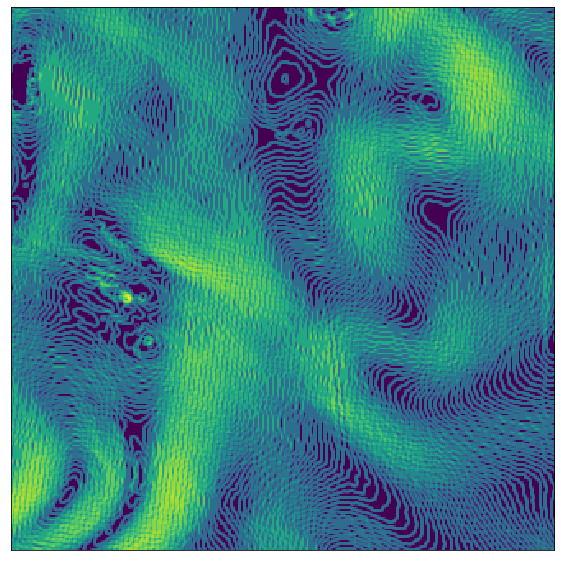

In [61]:
plot_utils.plot_matrix(eo_patch_test.data_timeless['DEM_SLOPE_LAYER'][1:-1,1:-1].squeeze())

In [62]:
water_features = eo_patch_test.mask_timeless['WATER_MASK_ST_025_COUNT']

In [63]:
import matplotlib.pyplot as plt

In [64]:
def plot_two_pictures_on_top_of_each_other(background_picture , mask, alpha):
    
    plt.figure(figsize=(10, 10))
    plt.imshow(background_picture.squeeze(), interpolation='none')
    plt.imshow(mask.squeeze(), interpolation='none', alpha=alpha)
    plt.show()

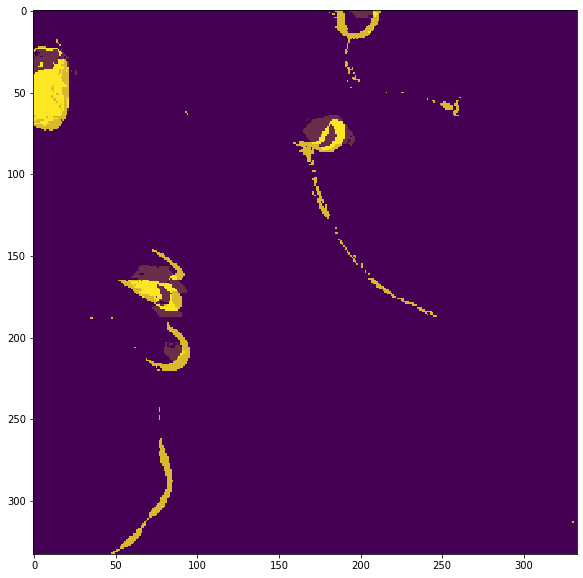

In [68]:
plot_two_pictures_on_top_of_each_other(reference_patch_test, inspected_patch_test, 0.2)

### Takeout: These model is similar as D5f i g and both of them can be applied to initial result production, this has better recall for water. - kind of better we have to compare it to the previous test dataset:

In [112]:
#import pickle

dataset_name = 'dataset_2013_05-2019_10_sptl_smpl_20000_pr_patch_unbalanced_classes_0_1_min_25_ test_7_patches'

with open('{}.pickle'.format(dataset_name), 'rb') as data:
    dataset = pickle.load(data)
    
features_train_cmp = dataset[0]
labels_train_cmp = dataset[1]
features_test_cmp = dataset[2]
labels_test_cmp = dataset[3]

In [114]:
# predict the test labels
print('TEST')
plabels_test_cmp = model.predict(features_test_cmp)
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test_cmp, plabels_test_cmp)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test_cmp, plabels_test_cmp, average='weighted')))

TEST
Classification accuracy 92.0%
Classification F1-score 90.6%


In [115]:
print('TRAIN')
# predict the train labels
plabels_train_cmp = model.predict(features_train_cmp)

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_train_cmp, plabels_train_cmp)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_train_cmp, plabels_train_cmp, average='weighted')))

TRAIN
Classification accuracy 91.9%
Classification F1-score 91.0%


In [116]:
actual_water_cmp = np.count_nonzero(labels_test_cmp)
predicted_water_cmp = np.count_nonzero(plabels_test_cmp)

print('Water Test data size:',actual_water_cmp)

tp_cmp = np.count_nonzero(np.logical_and(labels_test_cmp.squeeze(), plabels_test_cmp.squeeze()))
print('Water True positive:', tp_cmp, 'and recall', 100* tp_cmp /actual_water_cmp, 'and precision:', tp_cmp /predicted_water_cmp)

Water Test data size: 658892
Water True positive: 174909 and recall 26.545928619561323 and precision: 0.5979999316215939


In [117]:
class_labels = np.unique(labels_test)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [120]:

f1_scores = metrics.f1_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}% |  {2:2.1f}%  | {3:2.1f}%'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 95.7% |  98.3%  | 93.3%
         * water                = 36.8% |  26.5%  | 59.8%
